In [45]:
import numpy as np
from sklearn.datasets import load_iris

from tqdm import tqdm

In [46]:
def reset_ctx(func):
    def wrapper(self, *args, **kwargs):
        res = func(self, *args, **kwargs)
        self.ctx = None
        return res
    return wrapper


class Module:
    ctx = None
    is_init = False

    def __call__(self, x, *args, **kwargs):
        if not self.is_init:
            self.init(x, *args, **kwargs)
            self.is_init = True
        self.ctx = self.cache_ctx(x, *args, **kwargs)
        return self.forward(x, *args, **kwargs)

    def init(self, *args, **kwargs):
        pass

    def apply(self, *args, **kwargs):
        pass

    def reset_grad(self, *args, **kwargs):
        pass

    def cache_ctx(self, x, *args, **kwargs):
        pass


class Sequential(Module):
    def __init__(self, *args):
        self.modules = args

    def forward(self, x, **kwargs):
        for m in self.modules:
            x = m(x)
        return x

    def backward(self, d_out):
        for m in reversed(self.modules):
            d_out = m.backward(d_out)
        return d_out

    def apply(self, lr, f):
        for m in self.modules:
            m.apply(lr, f)
            m.reset_grad()

    def reset_grad(self):
        for m in self.modules:
            m.reset_grad()
    
    def __getitem__(self, idx):
        return self.modules[idx]


In [47]:
class ReLU(Module):
    def __init__(self):
        self.is_init = True

    def forward(self, x, *args, **kwargs):
        return np.maximum(0, x)

    def cache_ctx(self, x, *args, **kwargs):
        return x

    @reset_ctx
    def backward(self, c_out):
        x_cached = self.ctx
        d_x = c_out * (x_cached > 0)
        return d_x


class Linear(Module):
    def __init__(self, dim, use_bias=True):
        self.dim = dim
        self.use_bias = use_bias
        self.W = None
        self.b = None

    def init(self, x, **kwargs):
        self.W = np.random.normal(0, 0.01, (x.shape[-1], self.dim))
        if self.use_bias:
            self.b = np.zeros((1, self.dim))

    def forward(self, x, **kwargs):
        return np.dot(x, self.W) + self.b

    def cache_ctx(self, x, **kwargs):
        return x
    
    @reset_ctx
    def backward(self, d_out):
        x_cached = self.ctx
        self.d_w = np.dot(x_cached.T, d_out)
        if self.use_bias:
            self.d_b = np.sum(d_out, axis=0, keepdims=True)
        d_x = np.dot(d_out, self.W.T)
        return d_x
    
    def apply(self, lr, f):
        self.W = f(self.W, self.d_w, lr)
        if self.use_bias:
            self.b = f(self.b, self.d_b, lr)
        self.reset_grad()
        
    def reset_grad(self):
        self.d_w = None
        self.d_b = None


def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))


class BCEFromLogit(Module):
    def __init__(self):
        self.is_init = True
    
    def forward(self, pred, target):
        target = target.reshape(-1, 1)
        pred = sigmoid(pred)
        return -np.mean(target * np.log(pred) + (1 - target) * np.log(1 - pred))
    
    def cache_ctx(self, x, y, **kwargs):
        return x, y  
    
    @reset_ctx
    def backward(self):
        cached_pred, cached_target = self.ctx
        cached_target = cached_target.reshape(-1, 1)
        d_x = sigmoid(cached_pred) - cached_target
        d_x = d_x / len(cached_target)
        return d_x

def gradient_descent(param, grad, lr):
    return param - (lr * grad)

In [48]:
module = Linear(1)
loss_fn = BCEFromLogit()


In [49]:
x, y = load_iris(return_X_y=True)
x = x[:100]
y = y[:100]

In [50]:
epochs = 10000
lr = 0.0001

batch_size = 32
n_batches = x.shape[0] // batch_size

loss_log = []
idxs = np.arange(x.shape[0])

for epoch in tqdm(range(epochs)):
    for batch in range(n_batches):
        batch_idxs = np.random.choice(idxs, batch_size, replace=False)
        x_batch = x[batch_idxs]
        y_batch = y[batch_idxs]
        pred = module(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_log.append(loss)
        d_loss = loss_fn.backward()
        module.backward(d_loss)
        module.apply(lr, gradient_descent)
        module.reset_grad()

100%|██████████| 10000/10000 [00:02<00:00, 4659.88it/s]


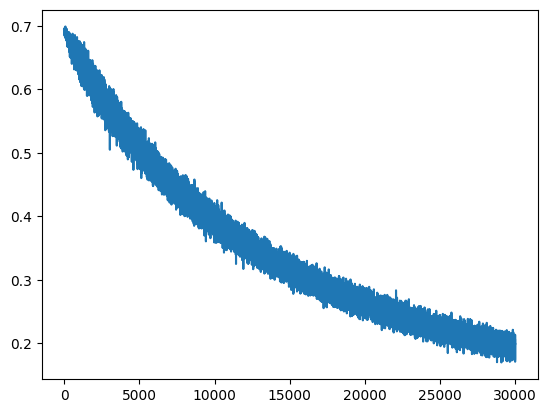

In [51]:
import matplotlib.pyplot as plt
plt.plot(loss_log)

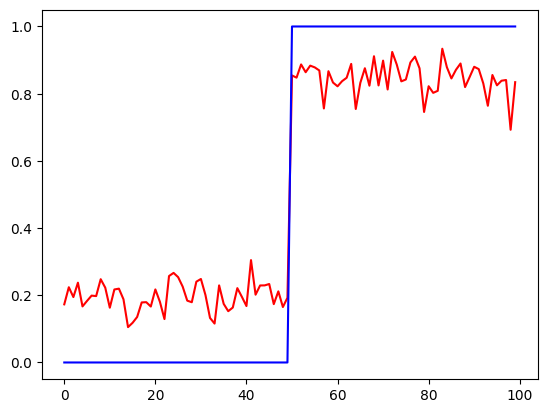

In [52]:
y_pred = sigmoid(module(x))

fig, ax = plt.subplots()
ax.plot(y_pred, c='red')
ax.plot(y, c='blue')

In [62]:
module = Sequential(
    Linear(2),
    ReLU(),
    Linear(1)
)
loss_fn = BCEFromLogit()

In [63]:
epochs = 100000
lr = 0.0001

batch_size = 32
n_batches = x.shape[0] // batch_size

loss_log = []
idxs = np.arange(x.shape[0])

for epoch in tqdm(range(epochs)):
    for batch in range(n_batches):
        batch_idxs = np.random.choice(idxs, batch_size, replace=False)
        x_batch = x[batch_idxs]
        y_batch = y[batch_idxs]
        pred = module(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_log.append(loss)
        d_loss = loss_fn.backward()
        module.backward(d_loss)
        module.apply(lr, gradient_descent)
        module.reset_grad()

100%|██████████| 100000/100000 [00:33<00:00, 2981.23it/s]


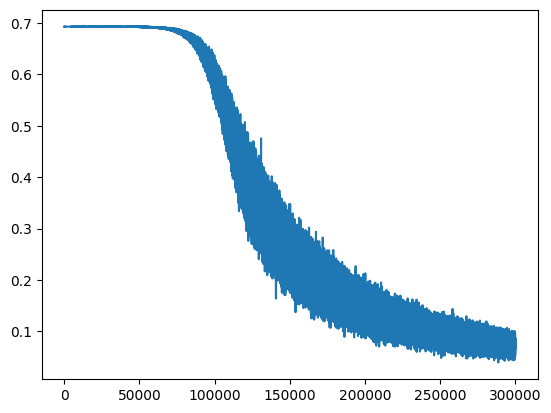

In [64]:
import matplotlib.pyplot as plt
plt.plot(loss_log)

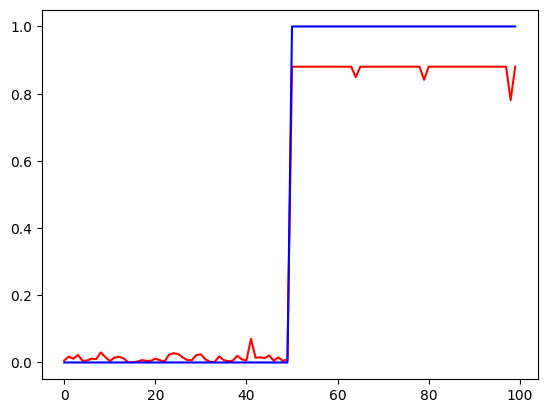

In [65]:
y_pred = sigmoid(module(x))

fig, ax = plt.subplots()
ax.plot(y_pred, c='red')
ax.plot(y, c='blue')